In [ ]:
import os
import math as m
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.core.fromnumeric import size


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Ganerating Data

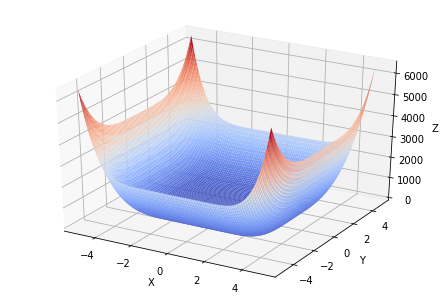

In [ ]:
def funZ(x,y):
  z=(4-2.1*m.pow(x,2)+m.pow(x,4)/3)*m.pow(x,2)+x*y+(-4+4*m.pow(y,2))*m.pow(y,2)
  return z
funZ = np.vectorize(funZ)
valueRange = np.arange(-5,5.1,0.1,np.float32)

fig1=plt.figure()#建立一個繪圖物件
ax=Axes3D(fig1)#用這個繪圖物件建立一個Axes物件(有3D座標)

X,Y=np.meshgrid(valueRange,valueRange)
Z=funZ(X,Y)
ax.plot_surface(X, Y, Z, rstride=1,cstride=1,cmap=plt.cm.coolwarm)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [ ]:
print(X[5][6] == Y[6][5])
print(size(Z))
print(funZ(X[5][6], Y[5][6]))
print(Z[5][6])
X = X.flatten()
Y = Y.flatten()
Z = Z.flatten()
print(X)
print(Y)
print(Z)

True
10201
3288.1633063750546
3288.1633060889526
[-5.        -4.9       -4.8       ...  4.7999907  4.89999    4.9999905]
[-5.        -5.        -5.        ...  4.9999905  4.9999905  4.9999905]
[6420.83333333 5923.69463908 5478.25693109 ... 5478.19803904 5923.62878221
 6420.76457373]


In [ ]:
xyPair = np.empty((size(X), 2))
for index, item in enumerate(X):
  xyPair[index] = [item, Y[index]]
print(xyPair)


[[-5.         -5.        ]
 [-4.9000001  -5.        ]
 [-4.80000019 -5.        ]
 ...
 [ 4.79999065  4.99999046]
 [ 4.89999008  4.99999046]
 [ 4.99999046  4.99999046]]


# Building the model

In [ ]:
class Network(nn.Module):
  def __init__(self):
      super(Network, self).__init__()
      self.flatten = nn.Flatten()
      self.networkStack = nn.Sequential(
          nn.Linear(in_features=2, out_features=256, bias=True),
          nn.ELU(),
          nn.Linear(256, 1024),
          nn.ELU(),
          nn.Linear(1024, 128),
          nn.ELU(),
          nn.Linear(128, 1),
      )

  def forward(self, x):
    #x = self.flatten(x)
    logits = self.networkStack(x)
    return logits

model = Network().to(device)

In [ ]:
print(model)
print(xyPair[4])
t = torch.from_numpy(xyPair[4]).to(device)
print(t.float)
print(model(t.float()))
print([Z[6]])

Network(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (networkStack): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=1024, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)
[-4.60000038 -5.        ]
<built-in method float of Tensor object at 0x7f74695b2d70>
tensor([0.0494], device='cuda:0', grad_fn=<AddBackward0>)
[4131.112626214423]


# Training
[Tutorial](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

In [ ]:
lossFunc = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-7)

def train(data):
  for index, input in enumerate(data):
    input = torch.from_numpy(input)
    input = input.to(device)
    prediction = model(input.float())
    #print(prediction)
    target = torch.tensor([Z[index]]).to(device)
    #print(target)
    loss = lossFunc(prediction, target.float())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if index % 1000 == 0:
      print(f"loss: {loss.item():>7f}  [{index:>5d}/{len(data):>5d}]")



In [ ]:
epochs = 100
for i in range(epochs):
  print(f"Epoch {i+1}\n-------------------------------")
  train(xyPair)
print("Done!")

Epoch 1
-------------------------------
loss: 41226432.000000  [    0/10201]
loss: 77622.437500  [ 1000/10201]
loss: 181560.531250  [ 2000/10201]
loss: 10298.722656  [ 3000/10201]
loss: 2186.650879  [ 4000/10201]
loss: 2218.786377  [ 5000/10201]
loss: 2433.119141  [ 6000/10201]
loss: 7359.781738  [ 7000/10201]
loss: 1386.191895  [ 8000/10201]
loss: 13286.417969  [ 9000/10201]
loss: 412613.031250  [10000/10201]
Epoch 2
-------------------------------
loss: 21004224.000000  [    0/10201]
loss: 449.158478  [ 1000/10201]
loss: 69362.484375  [ 2000/10201]
loss: 9656.342773  [ 3000/10201]
loss: 1949.390381  [ 4000/10201]
loss: 1802.238037  [ 5000/10201]
loss: 1886.406860  [ 6000/10201]
loss: 6387.736816  [ 7000/10201]
loss: 16047.886719  [ 8000/10201]
loss: 40864.386719  [ 9000/10201]
loss: 4088590.750000  [10000/10201]
Epoch 3
-------------------------------
loss: 33653308.000000  [    0/10201]
loss: 291.503937  [ 1000/10201]
loss: 19368.105469  [ 2000/10201]
loss: 8448.736328  [ 3000/10201

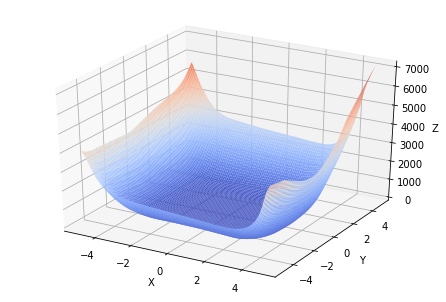

In [ ]:
def funModel(x,y):
  a = np.array([x,y])
  t = torch.from_numpy(a).to(device)
  result = model(t.float())
  return result.item()
funModel = np.vectorize(funModel)
valueRange = np.arange(-5,5.1,0.1,np.float32)

fig1=plt.figure()#建立一個繪圖物件
ax=Axes3D(fig1)#用這個繪圖物件建立一個Axes物件(有3D座標)

Xm,Ym=np.meshgrid(valueRange,valueRange)
Zm=funModel(Xm,Ym)
ax.plot_surface(Xm, Ym, Zm, rstride=1,cstride=1,cmap=plt.cm.coolwarm)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()